In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../src")

In [2]:
from PycalcAct.dataset import Dataset
from PycalcAct.model import (
    MixedFCTemporalModel,
)
from PycalcAct.trainer import Trainer


In [3]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",  # Optional
    position_to_displacement=True,  # Convert the x, y position to a single displacement value (sqrt((x(t+1)-x(t))^2 + (y(t+1)-y(t))^2)
)
model = MixedFCTemporalModel(
    n_fc_layers=1,
    n_rnn_layers=2,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=32,
    fc_hidden_size=128,
    dropout=0.15,
    bidirectional=True,
    use_gru=True,
)
n_epochs = 500
trainer = Trainer(
    dataset, model, device="cuda"
)  # You can pass your own optimizer, criterion and learning rate scheduler.


In [4]:
trainer.summary(optimizer=False, model=True, data=True)

Model
Layer (type:depth-idx)                   Output Shape              Param #
MixedFCTemporalModel                     [10, 4]                   --
├─GRU: 1-1                               [10, 120, 64]             25,728
├─Sequential: 1-2                        [10, 128]                 --
│    └─Sequential: 2-1                   [10, 128]                 --
│    │    └─Linear: 3-1                  [10, 128]                 983,168
│    │    └─ReLU: 3-2                    [10, 128]                 --
│    │    └─Dropout1d: 3-3               [10, 128]                 --
├─Linear: 1-3                            [10, 4]                   516
Total params: 1,009,412
Trainable params: 1,009,412
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 40.71
Input size (MB): 0.01
Forward/backward pass size (MB): 0.62
Params size (MB): 4.04
Estimated Total Size (MB): 4.67
Data
Dataset summary: timepoints 120, features 2
Class weights:
N4: 0.65 Q4: 0.84 Q4H7: 1.75 T4: 1.41 

,Total,N4,Q4,Q4H7,T4
Train,16084,6144,4790,2299,2851
Validation,4022,1536,1198,575,713
Test,5027,1920,1497,719,891
Total,25133,9600,7485,3593,4455


# Learning with Displacement encoding

╭───────────────────────────┬───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │            Loss           │          Accuracy         │         train loss        │
├───────────────────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                           │           19.44           │            1.39           │
│             1             │                           │           38.94           │            1.54           │
│             3             │                           │           47.69           │            1.34           │
│             4             │                           │           48.68           │            1.32           │
│             5             │                           │           49.30           │            1.29           │
│             36            │                           │           49.38           │   

/tmp/ipykernel_792772/3827735433.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_792772/3827735433.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


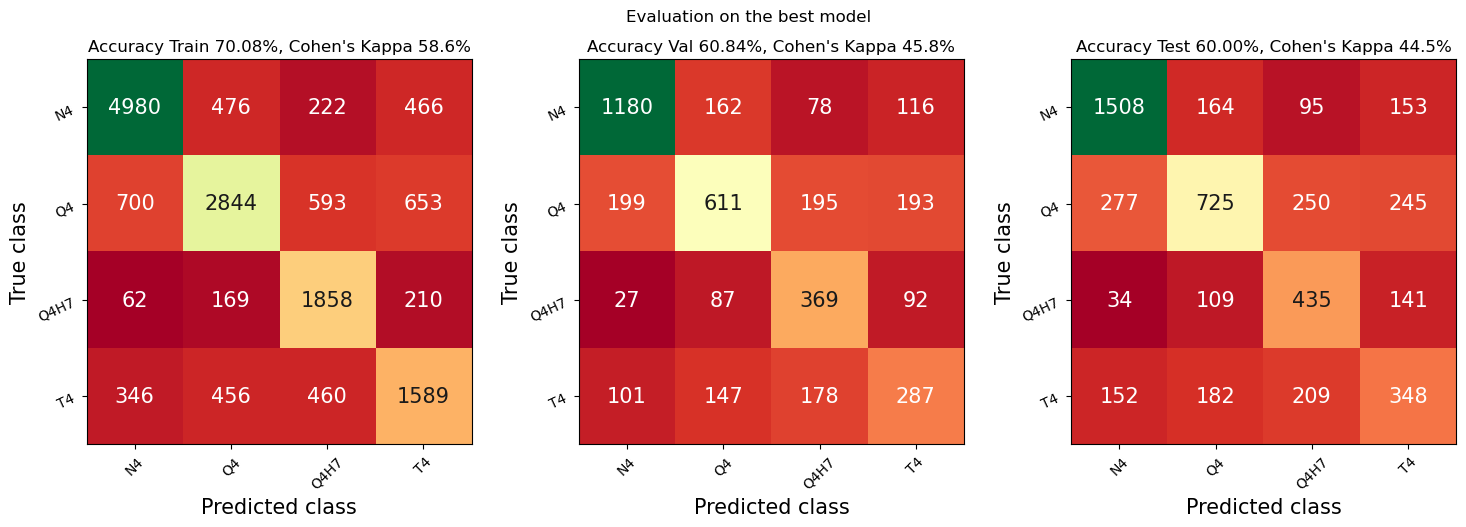

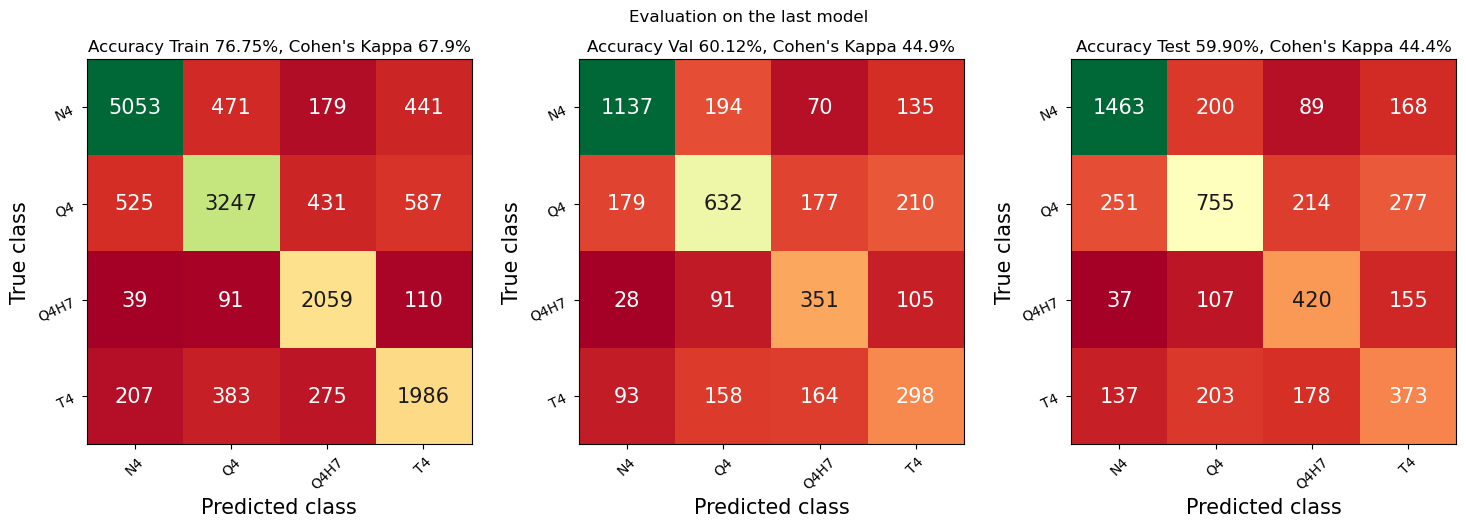

In [5]:
trainer.train(n_epochs)
fig = trainer.test("best")  # Testing on the best model (in term of validation accuracy)
fig.suptitle("Evaluation on the best model")
fig.show()
fig = trainer.test("last")  # Testing on the last model
fig.suptitle("Evaluation on the last model")
fig.show()

# Learning without displacement encoding

╭───────────────────────────┬───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │            Loss           │          Accuracy         │         train loss        │
├───────────────────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                           │           38.19           │            1.39           │
│             1             │                           │           49.53           │            1.43           │
│             59            │                           │           49.63           │            1.22           │
│             68            │                           │           49.68           │            1.17           │
│             69            │                           │           49.78           │            1.17           │
│             70            │                           │           49.98           │   

/tmp/ipykernel_792772/3285536839.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_792772/3285536839.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


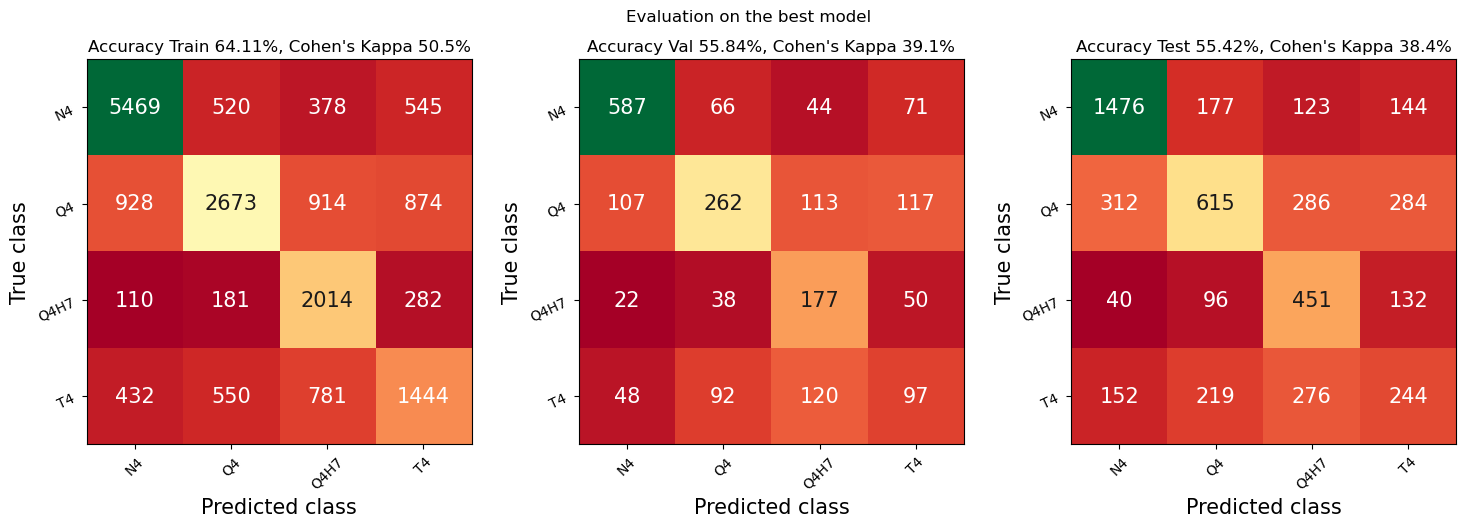

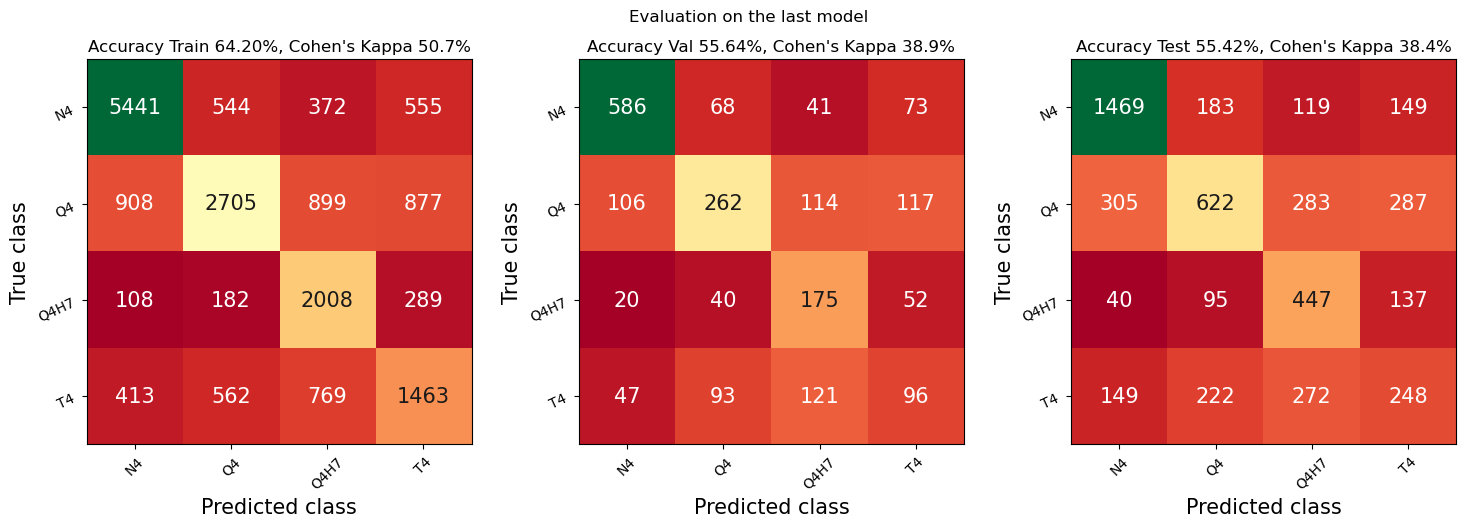

In [6]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    test_size=0.2,
    val_size=0.1,
)
model = MixedFCTemporalModel(
    n_fc_layers=1,
    n_rnn_layers=2,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=32,
    fc_hidden_size=128,
    dropout=0.15,
    bidirectional=True,
    use_gru=True,
)
n_epochs = 500
trainer = Trainer(
    dataset, model, device="cuda"
)  # You can pass your own optimizer, criterion and learning rate scheduler.

trainer.train(n_epochs)
fig = trainer.test("best")  # Testing on the best model (in term of validation accuracy)
fig.suptitle("Evaluation on the best model")
fig.show()
fig = trainer.test("last")  # Testing on the last model
fig.suptitle("Evaluation on the last model")
fig.show()

# Learning vastly overparametrized model and no regularization

╭───────────────────────────┬───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │            Loss           │          Accuracy         │         train loss        │
├───────────────────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                           │           40.28           │            1.39           │
│             3             │                           │           42.09           │            1.37           │
│             6             │                           │           46.32           │            1.28           │
│             7             │                           │           49.53           │            1.24           │
│             28            │                           │           49.90           │            1.18           │
│             31            │                           │           50.37           │   

/tmp/ipykernel_792772/3570871213.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_792772/3570871213.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


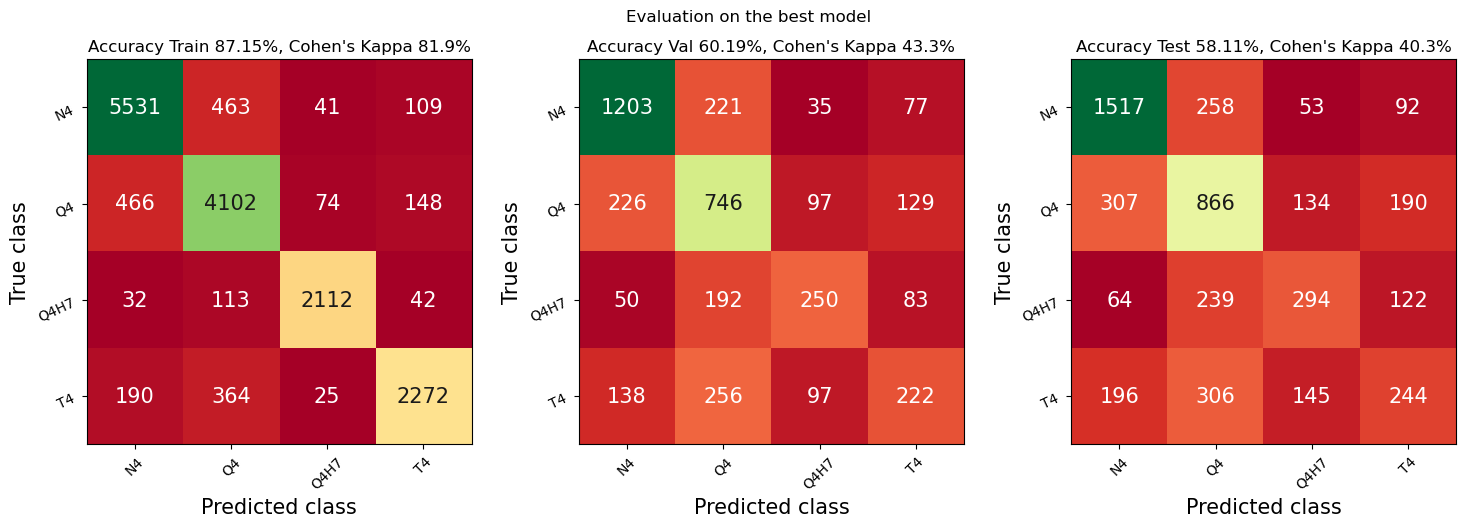

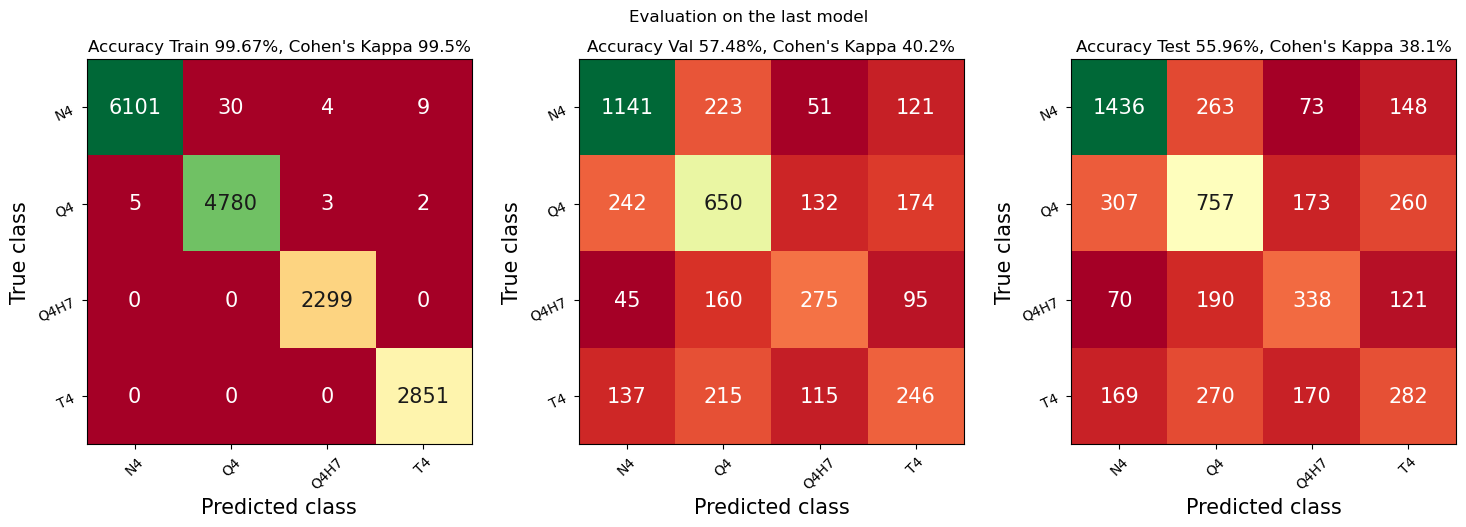

In [7]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",
    position_to_displacement=True,
)
model = MixedFCTemporalModel(
    n_fc_layers=2,
    n_rnn_layers=2,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=32,
    fc_hidden_size=512,
    dropout=0.0,
    bidirectional=True,
    use_gru=True,
)
n_epochs = 500
trainer = Trainer(
    dataset, model, device="cuda", weight_decay=0.0
)  # You can pass your own optimizer, criterion and learning rate scheduler.

trainer.train(n_epochs)
fig = trainer.test("best")  # Testing on the best model (in term of validation accuracy)
fig.suptitle("Evaluation on the best model")
fig.show()
fig = trainer.test("last")  # Testing on the last model
fig.suptitle("Evaluation on the last model")
fig.show()

# Learning vastly overparametrized model and strong regularization

╭───────────────────────────┬───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │            Loss           │          Accuracy         │         train loss        │
├───────────────────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                           │           42.94           │            1.39           │
│             3             │                           │           43.16           │            1.39           │
│             5             │                           │           43.21           │            1.35           │
│             6             │                           │           47.09           │            1.33           │
│             12            │                           │           48.66           │            1.31           │
│             17            │                           │           48.71           │   

/tmp/ipykernel_792772/2564492494.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_792772/2564492494.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


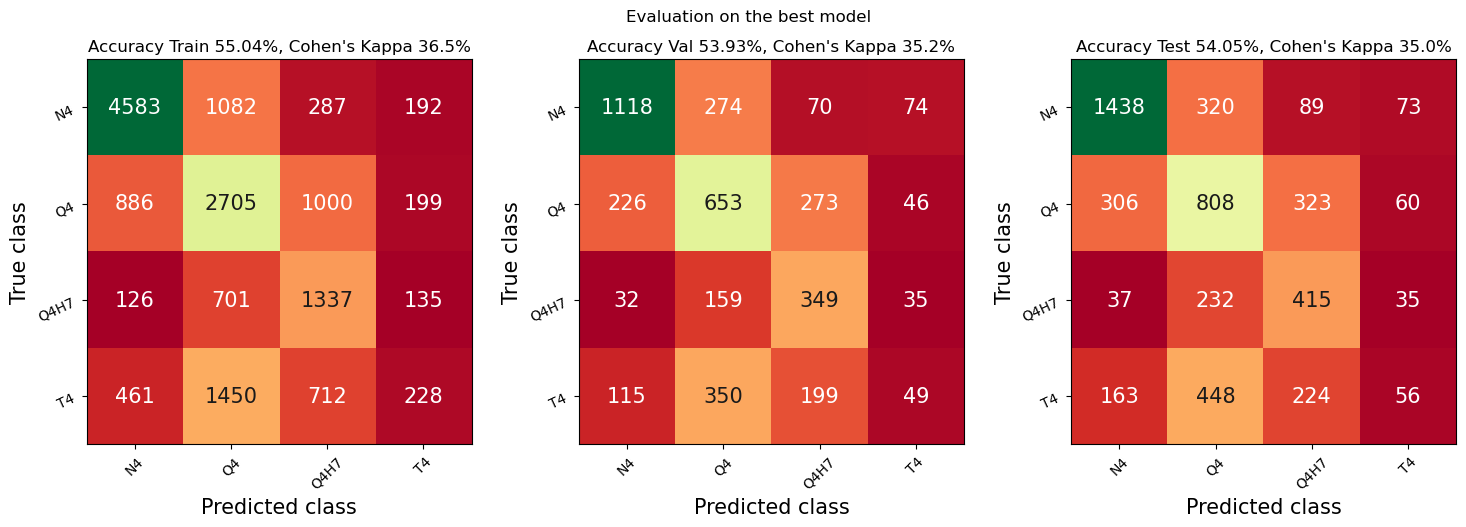

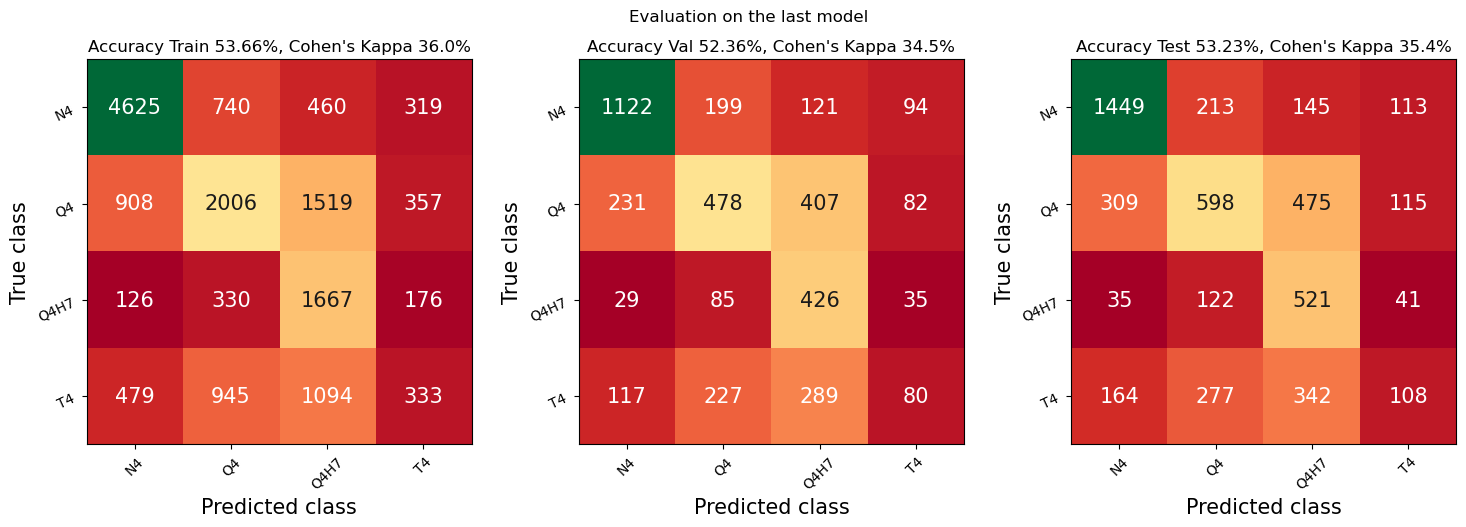

In [8]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",
    position_to_displacement=True,
)
model = MixedFCTemporalModel(
    n_fc_layers=2,
    n_rnn_layers=2,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=32,
    fc_hidden_size=512,
    dropout=0.3,
    bidirectional=True,
    use_gru=True,
)
n_epochs = 500
trainer = Trainer(
    dataset, model, device="cuda", weight_decay=0.01
)  # You can pass your own optimizer, criterion and learning rate scheduler.

trainer.train(n_epochs)
fig = trainer.test("best")  # Testing on the best model (in term of validation accuracy)
fig.suptitle("Evaluation on the best model")
fig.show()
fig = trainer.test("last")  # Testing on the last model
fig.suptitle("Evaluation on the last model")
fig.show()

# Tiny model

╭───────────────────────────┬───────────────────────────┬───────────────────────────┬───────────────────────────╮
│           Epoch           │            Loss           │          Accuracy         │         train loss        │
├───────────────────────────┼───────────────────────────┼───────────────────────────┼───────────────────────────┤
│             0             │                           │           23.10           │            1.39           │
│             10            │                           │           47.17           │            1.28           │
│             20            │                           │           47.27           │            1.20           │
│             30            │                           │           49.06           │            1.17           │
│             40            │                           │           49.78           │            1.15           │
│             50            │                           │           51.44           │   

/tmp/ipykernel_792772/2029793051.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_792772/2029793051.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


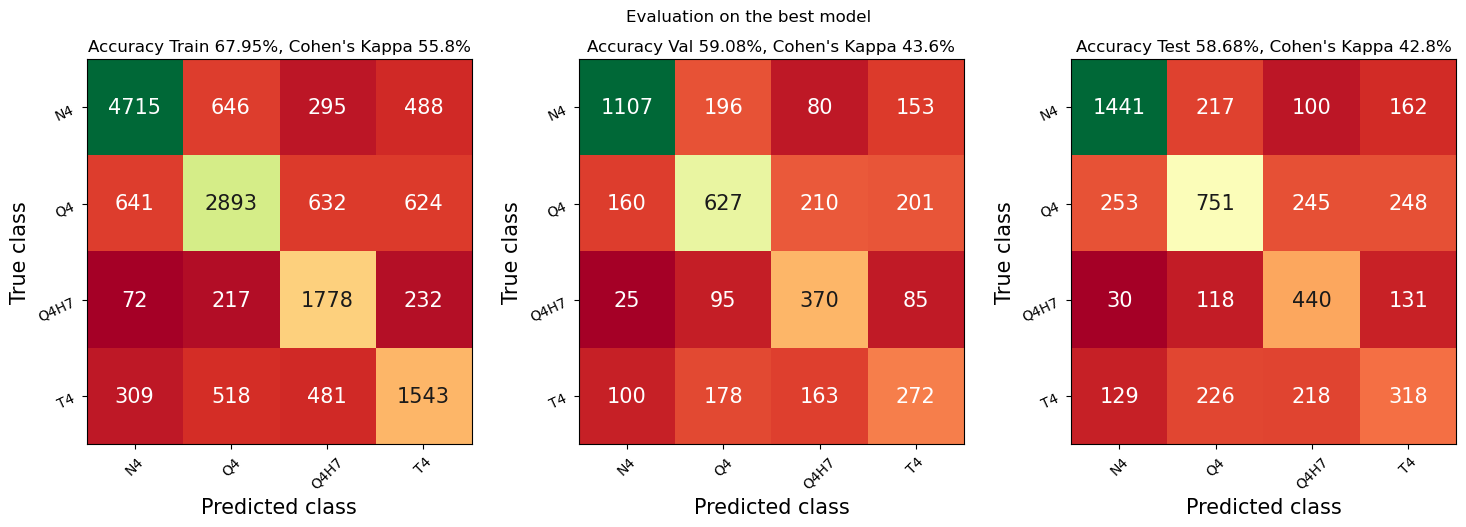

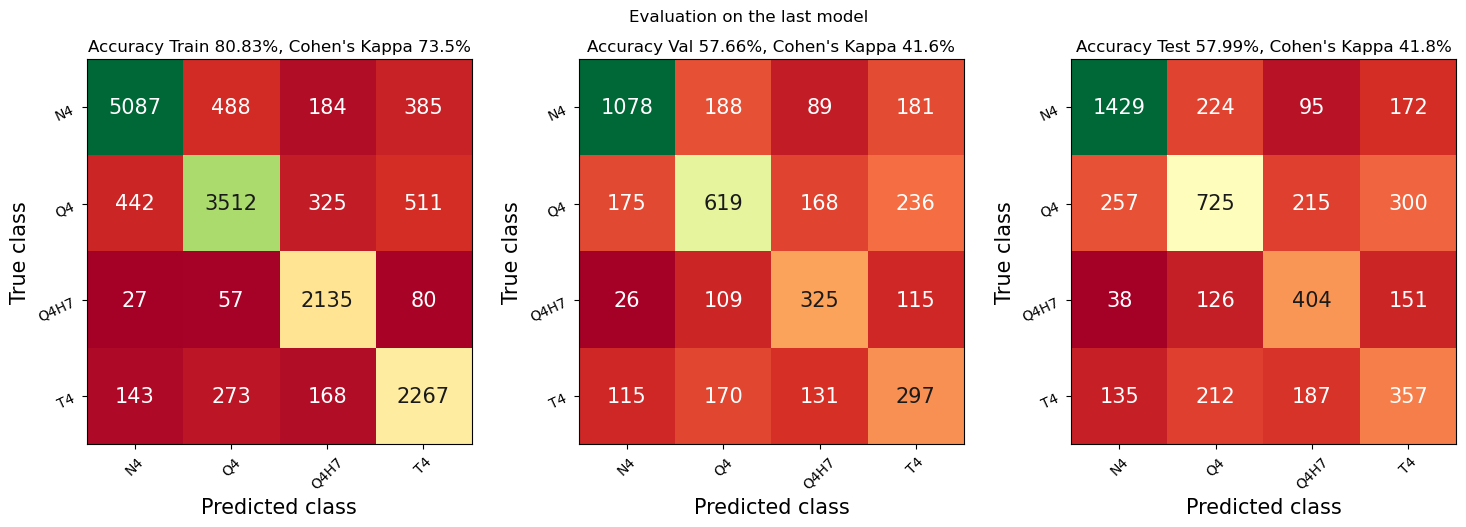

In [9]:
dataset = Dataset(
    csv_path="/home/clement/Documents/Sebastien/dataMcGill/legend.csv",
    csv_pos_path="/home/clement/Documents/Sebastien/dataMcGill/position.csv",
    position_to_displacement=True,
)
model = MixedFCTemporalModel(
    n_fc_layers=1,
    n_rnn_layers=1,
    n_classes=dataset.n_classes,
    temporal_length=dataset.length_serie,
    input_size=dataset.features,
    rnn_hidden_size=16,
    fc_hidden_size=16,
    dropout=0,
    bidirectional=True,
    use_gru=True,
)
n_epochs = 2500  # We train for more epochs as it is a smaller model (thus faster).
trainer = Trainer(
    dataset, model, device="cuda", weight_decay=1e-3
)  # You can pass your own optimizer, criterion and learning rate scheduler.

trainer.train(n_epochs, val_every=10)
fig = trainer.test("best")  # Testing on the best model (in term of validation accuracy)
fig.suptitle("Evaluation on the best model")
fig.show()
fig = trainer.test("last")  # Testing on the last model
fig.suptitle("Evaluation on the last model")
fig.show()